# Model

> Central diffusion model specification

This is adapted from my [FastAI notes]()

In [ ]:
# |default_exp model

In [ ]:
# |export
import math
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
import torch
from beartype import beartype
from jaxtyping import jaxtyped
from torch import nn

from slow_diffusion.typing import (
    InFeatureMapTensor,
    OutFeatureMapTensor,
    TimeStepEmbeddingTensor,
    TimeStepTensor,
)

In [ ]:
# |hide
plt.style.use("ggplot")

## Initialization

We need to make sure that our gradients do not explode or vanish. This should help us break down the apropriate initialization for each torch module.

In [ ]:
# |exports
class KaimingInitializable:
    """Helper mixin to facilitate initialization"""

    @staticmethod
    def apply_kaiming(module: torch.nn.Module) -> None:
        """Apply the module's custom kaiming initialization"""
        try:
            module._kaiming()
        except AttributeError:
            pass

    @classmethod
    def kaiming(cls, *args, **kwargs):
        model = cls(*args, **kwargs)
        model.apply(cls.apply_kaiming)
        return model

## Modules

Now, let's get to the module definitions.

The ConvBlock is laid out in the "Preactivation" configuration, like so:

![](https://www.researchgate.net/publication/337691625/figure/fig2/AS:831842160746496@1575338034408/Architecture-of-normal-residual-block-a-and-pre-activation-residual-block-b.jpg)

This does mean that we need to take care in the first block to use a "raw" nn.Conv, because otherwise the activation would discard pixel information.

In [ ]:
# |exports
class ConvBlock(nn.Module, KaimingInitializable):
    """Wrapper for a Conv block with normalization and activation"""

    def __init__(self, c_in: int, c_out: int, ks: int = 3, stride: int = 1):
        super().__init__()
        self.ks = ks
        self.norm = nn.BatchNorm2d(c_in)
        self.act = nn.ReLU()  # 👈 SwiGLU?
        self.conv = nn.Conv2d(
            c_in,
            c_out,
            stride=stride,
            kernel_size=ks,
            padding=ks // 2,
            bias=False,
        )

    @jaxtyped(typechecker=beartype)
    def forward(self, x: InFeatureMapTensor) -> OutFeatureMapTensor:
        x = self.norm(x)
        x = self.act(x)
        x = self.conv(x)
        return x

    def _kaiming(self):
        if isinstance(self.act, (nn.ReLU,)):
            torch.nn.init.kaiming_normal_(self.conv.weight, a=0.0)
        else:
            raise ValueError
        if self.conv.bias is not None:
            torch.nn.init.constant_(self.conv.bias, 0)

Let's verify that the distribution remains normal after the transformation is applied.

In [ ]:
def plot_distribution_variance(args, modules: list[tuple[str, nn.Module]]):
    fig, axes = plt.subplots(1, len(modules), figsize=(4 * len(modules), 4))
    for ax, (label, c) in zip(axes, cs):
        _, bins, _ = ax.hist(xb.reshape(-1), bins=30, alpha=0.5, label="input")
        with torch.no_grad():
            yb = c(*args)
        ax.hist(yb.reshape(-1), bins, alpha=0.33, label=label)
        ax.set(xlabel="Logit magnitude", ylabel="Frequency", title=label)

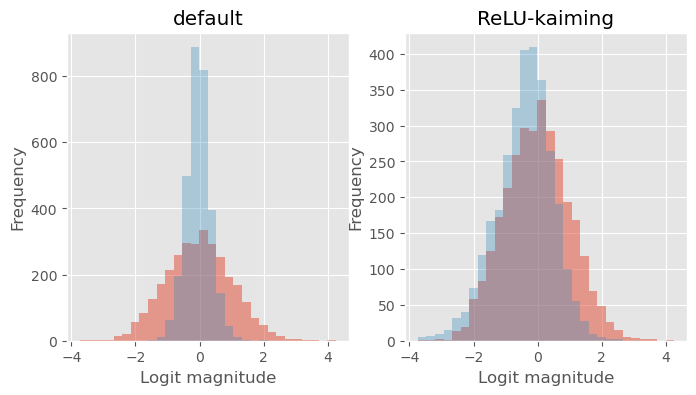

In [ ]:
xb = torch.randn(16, 3, 8, 8)
cs = [("default", ConvBlock(3, 3)), ("ReLU-kaiming", ConvBlock.kaiming(3, 3))]
plot_distribution_variance((xb,), cs)

Good! The Kaiming methods preserve the distribution variance, unlike default.

In [ ]:
# |exports
@jaxtyped(typechecker=beartype)
def timestep_embedding(
    ts: TimeStepTensor, emb_dim: int, max_period: int = 10_000
) -> TimeStepEmbeddingTensor:
    exponent = -math.log(max_period) * torch.linspace(
        0, 1, emb_dim // 2, device=ts.device
    )
    embedding = ts[:, None].float() * exponent.exp()[None, :]
    embedding = torch.cat([embedding.sin(), embedding.cos()], dim=-1)
    return embedding

In [ ]:
# |exports
class TimeEmbeddingMixer(nn.Module, KaimingInitializable):
    """Incorporate the time embedding into the ResBlock logits"""

    def __init__(self, c_time, c_out):
        super().__init__()
        self.lin = nn.Linear(c_time, c_out * 2)
        self.act = nn.ReLU()  # 👈 SwiGLU?

    @jaxtyped(typechecker=beartype)
    def forward(
        self, x: InFeatureMapTensor, t_emb: TimeStepEmbeddingTensor
    ) -> OutFeatureMapTensor:
        t_emb = self.lin(self.act(t_emb))[:, :, None, None]
        scale, shift = torch.chunk(t_emb, 2, dim=1)
        return x * (1 + scale) + shift

It looks like `TimeEmbeddingMixer` does not require Kaiming initialization.

```python
# ...snip

    def _kaiming(self):
        if isinstance(self.act, (nn.ReLU,)):
            torch.nn.init.kaiming_normal_(self.lin.weight)
        else:
            raise ValueError
        if self.lin.bias is not None:
            torch.nn.init.constant_(self.lin.bias, 0)

bs = xb.shape[0]
ts: TimeStepTensor = torch.linspace(-10, 10, bs)
tse = timestep_embedding(ts, 32)
cs = [
    ("default", TimeEmbeddingMixer(32, 3)),
    ("ReLU-kaiming", TimeEmbeddingMixer.kaiming(32, 3)),
]
plot_distribution_variance((xb, tse), cs)
```

![](../docs/time_embedding_mixer_does_not_require_kaiming.png)

Notice that the distribution becomes more left skewed when you do this.

In [ ]:
# |exports
class ResBlock(
    nn.Module,
    KaimingInitializable,
):
    """Conv resblock with the preactivation configuration and time embedding modulation"""

    def __init__(
        self, c_time: int, c_in: int, c_out: int, ks: int = 3, stride: int = 2
    ):
        super().__init__()
        self.c_time = c_time
        self.c_in = c_in
        self.c_out = c_out

        self.time_mixer = TimeEmbeddingMixer(c_time, c_out)
        self.conv_a = ConvBlock(c_in, c_out)
        self.conv_b = ConvBlock(c_out, c_out)
        if c_in != c_out:
            self.id_conv = nn.Conv2d(c_in, c_out, kernel_size=1)
        else:
            self.id_conv = None

        self.output = None

    def non_residual(self, x, t_emb):
        x = self.conv_a(x)
        x = self.time_mixer(x, t_emb)
        x = self.conv_b(x)
        return x

    def residual(self, x):
        if self.id_conv is not None:
            return self.id_conv(x)
        else:
            return x

    @jaxtyped(typechecker=beartype)
    def forward(
        self, x: InFeatureMapTensor, t_emb: TimeStepEmbeddingTensor
    ) -> OutFeatureMapTensor:
        x = self.non_residual(x, t_emb) + self.residual(x)
        self.output = x
        return x

In [ ]:
bs = xb.shape[0]
ts: TimeStepTensor = torch.linspace(-10, 10, bs)
tse = timestep_embedding(ts, 32)
tse.shape

torch.Size([16, 32])

In [ ]:
ts

tensor([-10.0000,  -8.6667,  -7.3333,  -6.0000,  -4.6667,  -3.3333,  -2.0000,
         -0.6667,   0.6667,   2.0000,   3.3333,   4.6667,   6.0000,   7.3333,
          8.6667,  10.0000])

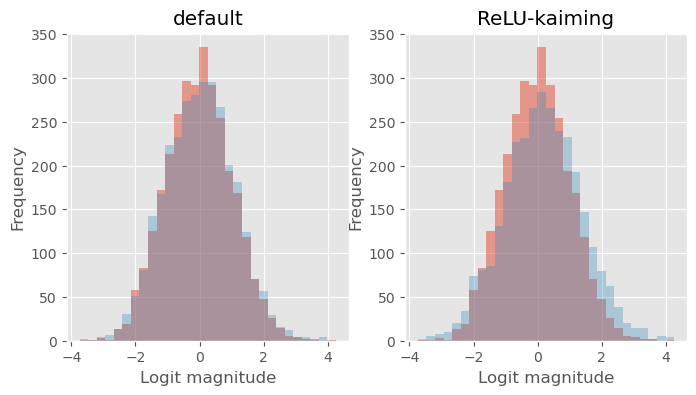

In [ ]:
cs = [("default", ResBlock(32, 3, 3)), ("ReLU-kaiming", ResBlock.kaiming(32, 3, 3))]
plot_distribution_variance((xb, tse), cs)

In [ ]:
# |exports
class Downblock(nn.Module):
    """A superblock consisting of many downblocks of similar resolutions"""

    def __init__(self, c_time, c_in, c_out, downsample=True, n_layers=1):
        super().__init__()
        self.c_time = c_time
        self.c_in = c_in
        self.c_out = c_out
        self.downsample = downsample
        self.n_layers = n_layers

        self.convs = nn.ModuleList()
        self.convs.append(ResBlock(c_time, c_in, c_out, stride=1))
        for _ in range(n_layers - 1):
            self.convs.append(ResBlock(c_time, c_out, c_out, stride=1))
        self.downsampler = nn.Conv2d(c_out, c_out, kernel_size=3, stride=2, padding=1)

    @jaxtyped(typechecker=beartype)
    def forward(
        self, x: InFeatureMapTensor, t: TimeStepEmbeddingTensor
    ) -> OutFeatureMapTensor:
        for conv in self.convs:
            x = conv(x, t)
        if self.downsample:
            x = self.downsampler(x)
        return x

In [ ]:
d = Downblock(32, 3, 2)
with torch.no_grad():
    yb = d(xb, tse)
xb.shape, yb.shape

(torch.Size([16, 3, 8, 8]), torch.Size([16, 2, 4, 4]))

In [ ]:
# |exports
class Upblock(nn.Module):
    """A superblock consisting of many upblocks of similar resolutions
    and logic to use the activations of the counterpart downblock."""

    def __init__(self, c_time, c_in, c_out, upsample=True, n_layers=1):
        super().__init__()
        self.c_time = c_time
        self.c_in = c_in
        self.c_out = c_out
        self.upsample = upsample
        self.n_layers = n_layers

        self.upsampler = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(c_in, c_in, kernel_size=3, padding=1),
        )
        self.convs = nn.ModuleList()
        for _ in range(n_layers - 1):
            self.convs.append(ResBlock(c_time, c_in * 2, c_in, stride=1))
        self.convs.append(ResBlock(c_time, c_in * 2, c_out, stride=1))

    @classmethod
    def from_downblock(cls, downblock):
        return cls(
            c_time=downblock.c_time,
            c_in=downblock.c_out,
            c_out=downblock.c_in,
            upsample=downblock.downsample,
            n_layers=downblock.n_layers,
        )

    @jaxtyped(typechecker=beartype)
    def forward(
        self, x: InFeatureMapTensor, downblock: Downblock, t: TimeStepEmbeddingTensor
    ) -> OutFeatureMapTensor:
        if self.upsample:
            x = self.upsampler(x)
        for up, down in zip(self.convs, reversed(downblock.convs)):
            x = up(torch.cat((x, down.output), dim=1), t)
        return x

In [ ]:
u = Upblock.from_downblock(d)
with torch.no_grad():
    xp = u(yb, d, tse)
xb.shape == xp.shape

True

In [ ]:
# |exports
class TimeEmbeddingMLP(nn.Module):
    """Small neural network to modify the "raw" time embeddings"""

    def __init__(self, c_in: int, c_out: int):
        super().__init__()
        self.c_in = c_in
        self.c_out = c_out
        self.time_emb_mlp = nn.Sequential(
            nn.BatchNorm1d(c_in),
            nn.Linear(c_in, c_out),
            nn.ReLU(),
            nn.Linear(c_out, c_out),
        )

    @jaxtyped(typechecker=beartype)
    def forward(self, t: TimeStepTensor) -> TimeStepEmbeddingTensor:
        # Look up the sin/cos embedding  of the time step
        x = timestep_embedding(t, self.c_in).to(t.device)
        # Allow the model to slightly modify the embeddings
        x = self.time_emb_mlp(x)
        return x

In [ ]:
# |exports
class Unet(nn.Module):
    """Diffusion U-net with a diffusion time dimension"""

    def __init__(
        self,
        nfs: Sequence[int],
        n_blocks: Sequence[int],
        color_channels: int = 3,
    ):
        assert len(n_blocks) - 1 == len(nfs)
        super().__init__()

        self.time_embedding = TimeEmbeddingMLP(nfs[0], 4 * nfs[0])
        c_time = self.time_embedding.c_out

        # Since we use pre-activation ResBlocks, we need to use a Conv2d here
        # to avoid discarding pixel information
        self.start = nn.Conv2d(
            color_channels, nfs[0], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        )
        self.downblocks = nn.ModuleList()
        self.upblocks = nn.ModuleList()
        for c_in, c_out, n_layers in zip(nfs, nfs[1:], n_blocks):
            db = Downblock(
                c_time,
                c_in,
                c_out,
                n_layers=n_layers,
            )
            self.downblocks.append(db)
            self.upblocks.insert(0, Upblock.from_downblock(db))
        self.middle = ResBlock(c_time, nfs[-1], nfs[-1], stride=1)
        self.end = ConvBlock(nfs[0], color_channels)

    # Uniquely for a U-net module output dimensions must match the input dimensions
    @jaxtyped(typechecker=beartype)
    def forward(
        self, x_t: InFeatureMapTensor, t: TimeStepEmbeddingTensor
    ) -> InFeatureMapTensor:
        t = self.time_embedding(t)
        x = self.start(x_t)
        for db in self.downblocks:
            x = db(x, t)
        x = self.middle(x, t)
        for ub, db in zip(self.upblocks, reversed(self.downblocks)):
            x = ub(x, db, t)
        return self.end(x)

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()